### Step 1: Import Libraries

In [14]:
# Step 1: Import Libraries
import os
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score, accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

### Step 2: Load Data Using PySpark

In [15]:
# Start Spark session
spark = SparkSession.builder.appName("InsuranceModel").getOrCreate()

# Define file path and load the data into a Spark DataFrame
file_path = r"C:\Users\HP\Desktop\Project-4-Team-2\CSVs\insurance.csv"
df_spark = spark.read.csv(file_path, header=True, inferSchema=True)

# Convert Spark DataFrame to Pandas DataFrame for use with scikit-learn
df = df_spark.toPandas()
df.head()


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [16]:
# Step 3: Data Cleaning, Normalization, and Standardization
df.dropna(inplace=True)

# Convert categorical columns to category type if needed
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype('category')

# Standardize numerical features
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Convert categorical variables to numeric using one-hot encoding
df = pd.get_dummies(df, drop_first=True)
df.columns

Index(['age', 'bmi', 'children', 'charges', 'sex_male', 'smoker_yes',
       'region_northwest', 'region_southeast', 'region_southwest'],
      dtype='object')

In [17]:
# Separate features and target variable
X = df.drop("charges", axis=1)  # Assuming 'charges' is the target column
y = df["charges"]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Step 4: Initialize, Train, and Evaluate Models

In [18]:
# Linear Regression with Polynomial Features and Ridge Regularization
poly_lr_model = Pipeline([
    ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('ridge_regression', Ridge())
])

# Perform cross-validation and calculate R-squared scores
cv_scores_poly_lr = cross_val_score(poly_lr_model, X_train, y_train, cv=5, scoring='r2')
print(f"Polynomial Linear Regression (Ridge) R-squared: {cv_scores_poly_lr.mean():.3f} ± {cv_scores_poly_lr.std():.3f}")

# For Random Forest Classifier:
# Convert y to binary for classification (above/below median charges)
y_train_class = np.where(y_train > y_train.median(), 1, 0)
y_test_class = np.where(y_test > y_test.median(), 1, 0)

# Initialize the random forest classifier
rf_model = RandomForestClassifier(random_state=12)

# Perform cross-validation and calculate accuracy scores for initial model
cv_scores_rf = cross_val_score(rf_model, X_train, y_train_class, cv=5, scoring='accuracy')
print(f"Initial Random Forest Classification Accuracy: {cv_scores_rf.mean():.3f} ± {cv_scores_rf.std():.3f}")

Polynomial Linear Regression (Ridge) R-squared: 0.827 ± 0.046
Initial Random Forest Classification Accuracy: 0.921 ± 0.009


### Step 5: Model Optimization with Grid Search for Random Forest

In [19]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search
grid_search_rf = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy')
grid_search_rf.fit(X_train, y_train_class)

# Get the best estimator and evaluate it
best_rf_model = grid_search_rf.best_estimator_
y_pred_best_rf = best_rf_model.predict(X_test)
best_accuracy_rf = accuracy_score(y_test_class, y_pred_best_rf)

print(f"Optimized Random Forest Accuracy: {best_accuracy_rf:.3f}")
print(f"Best Hyperparameters: {grid_search_rf.best_params_}")

Optimized Random Forest Accuracy: 0.933
Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}


### Step 6: Save Model Performance Results

In [20]:
# Step 6: Save Model Performance Results
# Record optimization process and results
results = {
    'Model': ['Initial Random Forest', 'Optimized Random Forest', 'Polynomial Linear Regression (Ridge)'],
    'Metric': ['Accuracy', 'Accuracy', 'R-squared'],
    'Score': [cv_scores_rf.mean(), best_accuracy_rf, cv_scores_poly_lr.mean()],
    'Hyperparameters': ['Default', str(grid_search_rf.best_params_), 'Polynomial Degree=2 with Ridge']
}

results_df = pd.DataFrame(results)
results_df.to_csv("model_optimization_results.csv", index=False)
print("Optimization results saved to CSV.")

# Step 7: Print Final Model Performance
print("\nFinal Model Performance Results:")
results_df

Optimization results saved to CSV.

Final Model Performance Results:


,Model,Metric,Score,Hyperparameters
0,Initial Random Forest,Accuracy,0.921495,Default
1,Optimized Random Forest,Accuracy,0.932836,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_..."
2,Polynomial Linear Regression (Ridge),R-squared,0.826984,Polynomial Degree=2 with Ridge


### Distribution and Summary Visualizations

##### Bar plot for model performance

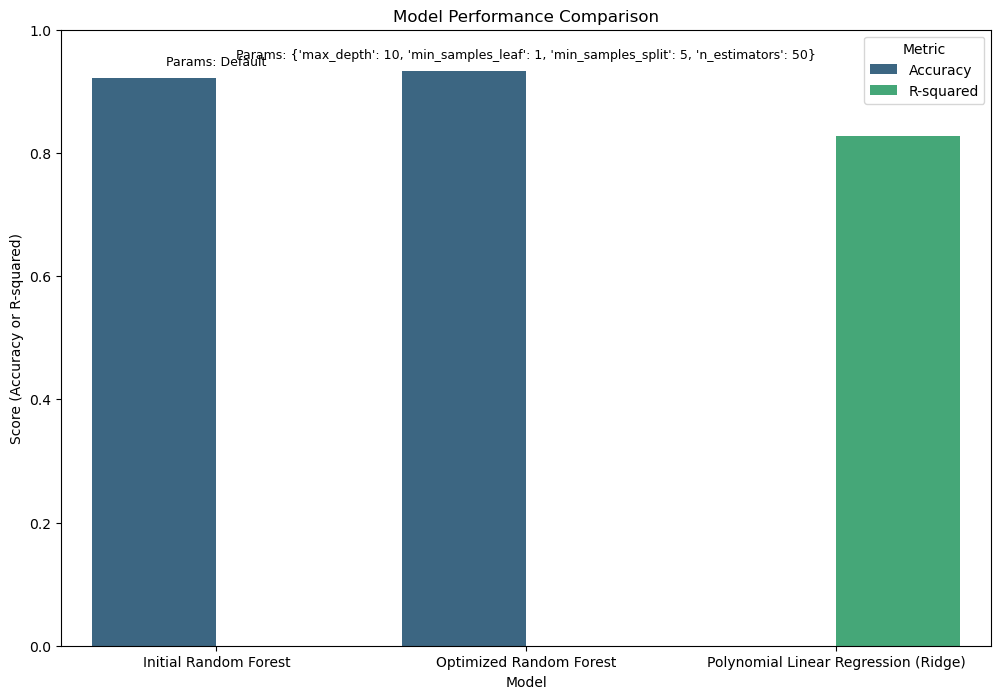

In [21]:
# Create a bar plot for model performance
plt.figure(figsize=(12, 8))
sns.barplot(data=results_df, x='Model', y='Score', hue='Metric', palette="viridis")

# Add titles and labels
plt.title("Model Performance Comparison")
plt.xlabel("Model")
plt.ylabel("Score (Accuracy or R-squared)")
plt.ylim(0, 1)  # Setting y-axis limit from 0 to 1 for clarity

# Display the hyperparameters as annotations for the Random Forest models
for index, row in results_df.iterrows():
    if 'Random Forest' in row['Model']:
        plt.text(index, row['Score'] + 0.02, f"Params: {row['Hyperparameters']}", ha='center', fontsize=9)

plt.legend(title="Metric")
plt.show()

#### 1. Histogram of Charges:

c:\Users\HP\New folder\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


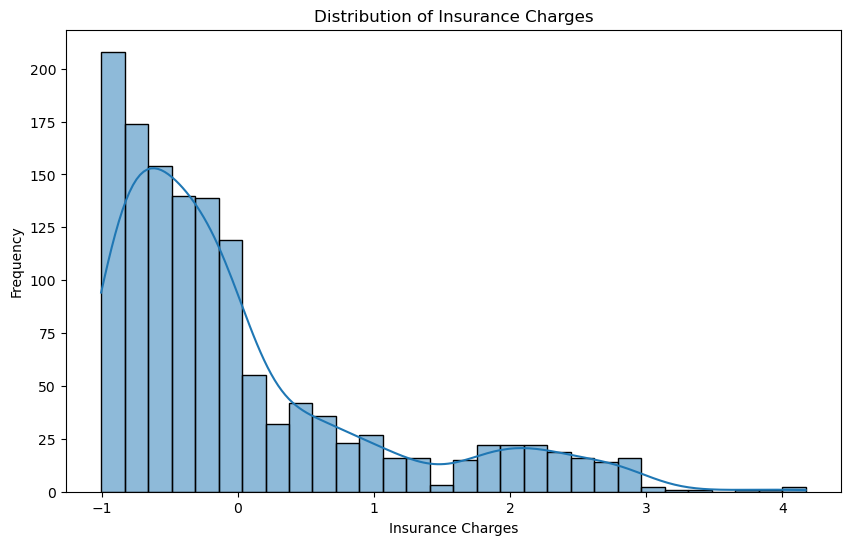

In [22]:
plt.figure(figsize=(10, 6))
sns.histplot(df['charges'], kde=True)
plt.title("Distribution of Insurance Charges")
plt.xlabel("Insurance Charges")
plt.ylabel("Frequency")
plt.show()

#### 2. Box Plots by Smoker Status and Gender: Male

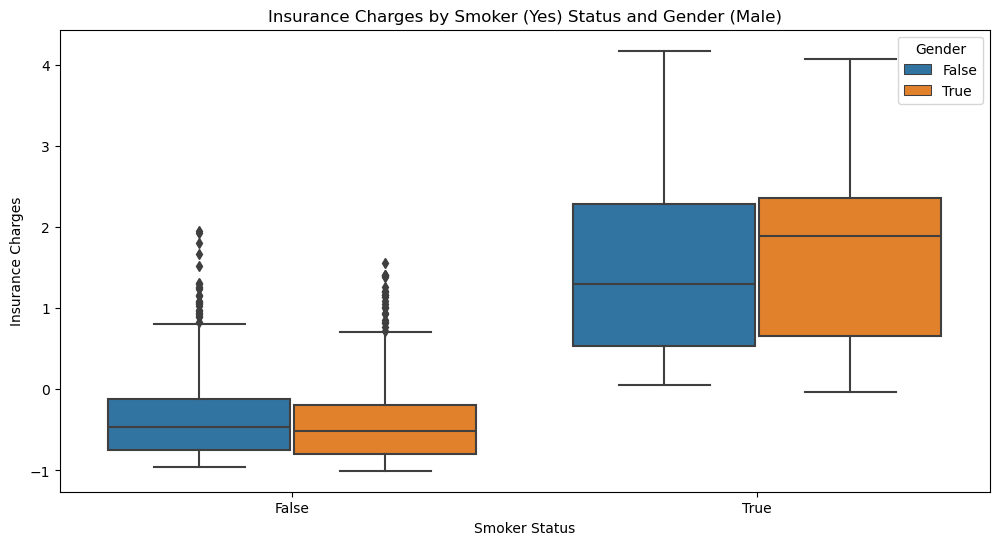

In [23]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='smoker_yes', y='charges', hue='sex_male')
plt.title("Insurance Charges by Smoker (Yes) Status and Gender (Male)")
plt.xlabel("Smoker Status")
plt.ylabel("Insurance Charges")
plt.legend(title="Gender")
plt.show()

#### 3.Kernel Density Estimate (KDE) Plot of BMI and Age:



C:\Windows\Temp\ipykernel_23832\504763136.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['bmi'], shade=True, label="BMI")
c:\Users\HP\New folder\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Windows\Temp\ipykernel_23832\504763136.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['age'], shade=True, label="Age")
c:\Users\HP\New folder\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_c

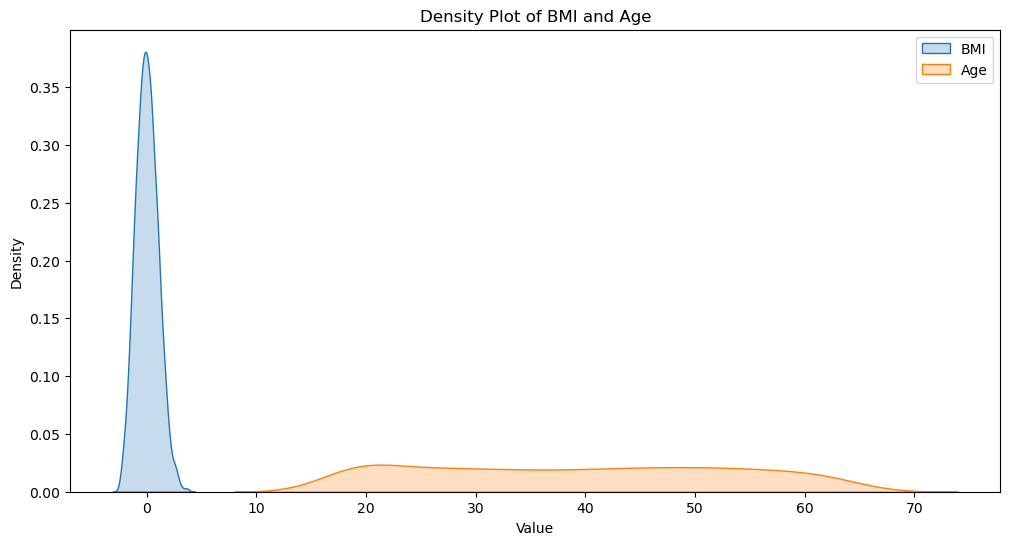

In [24]:
plt.figure(figsize=(12, 6))
sns.kdeplot(df['bmi'], shade=True, label="BMI")
sns.kdeplot(df['age'], shade=True, label="Age")
plt.title("Density Plot of BMI and Age")
plt.xlabel("Value")
plt.legend()
plt.show()

###  Comparative Visualizations for Key Drivers

#### 1 Scatter Plot of Age vs. Charges, Colored by Smoker Status

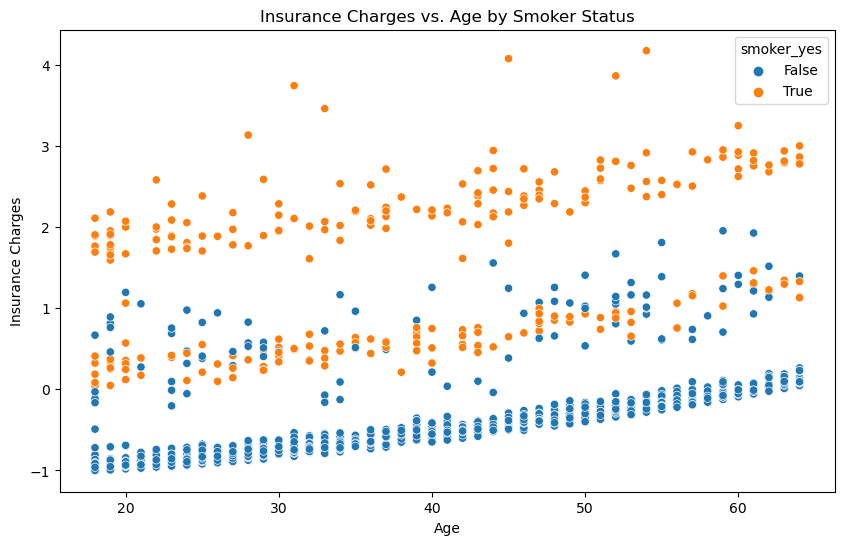

In [25]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='age', y='charges', hue='smoker_yes')
plt.title("Insurance Charges vs. Age by Smoker Status")
plt.xlabel("Age")
plt.ylabel("Insurance Charges")
plt.show()

#### 2. Scatter Plot of BMI vs. Charges, Colored by Smoking Status:

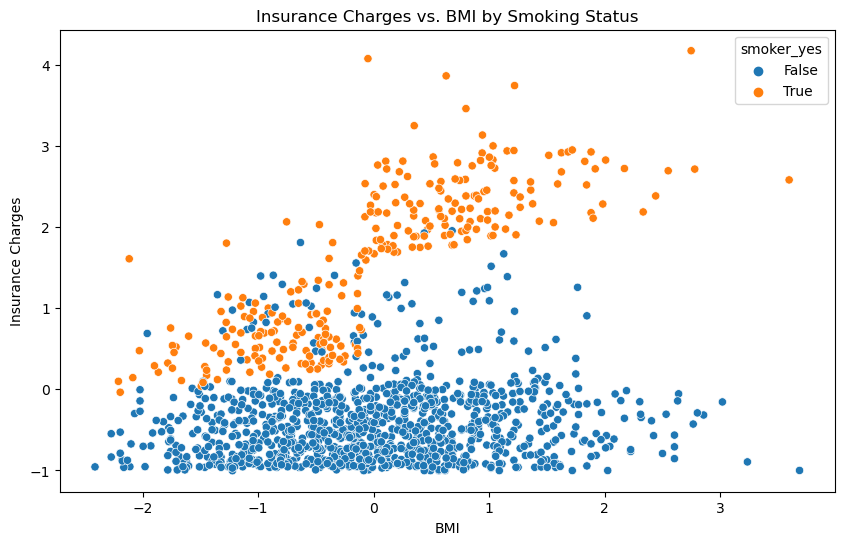

In [26]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='bmi', y='charges', hue='smoker_yes')
plt.title("Insurance Charges vs. BMI by Smoking Status")
plt.xlabel("BMI")
plt.ylabel("Insurance Charges")
plt.show()

#### 3. Heatmap of Correlation Matrix:

##### 1 a. Northwest

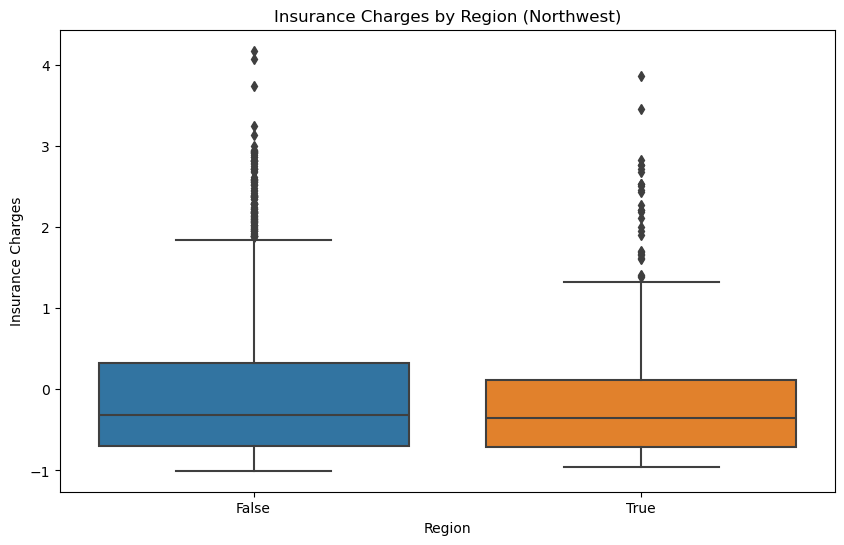

In [27]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='region_northwest', y='charges')
plt.title("Insurance Charges by Region (Northwest)")
plt.xlabel("Region")
plt.ylabel("Insurance Charges")
plt.show()

#### 1 b. Southwest

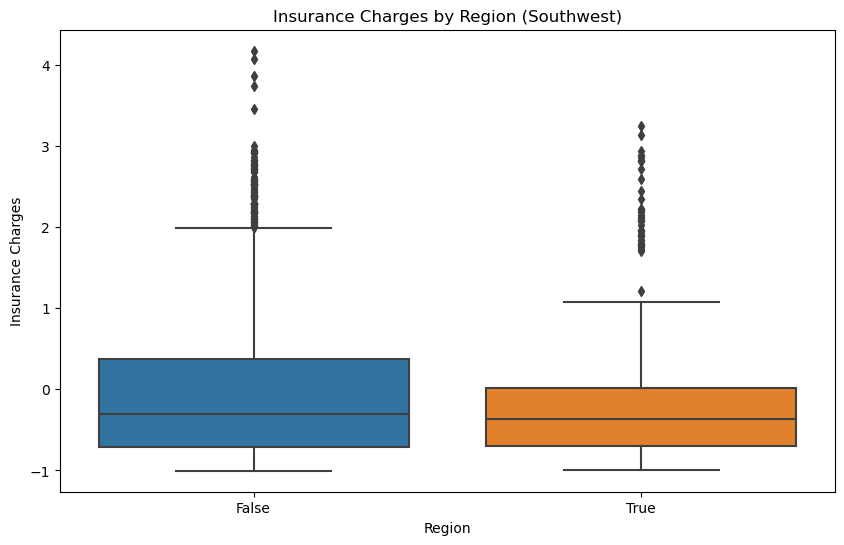

In [28]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='region_southwest', y='charges')
plt.title("Insurance Charges by Region (Southwest)")
plt.xlabel("Region")
plt.ylabel("Insurance Charges")
plt.show()

#### 1 c. Southeast

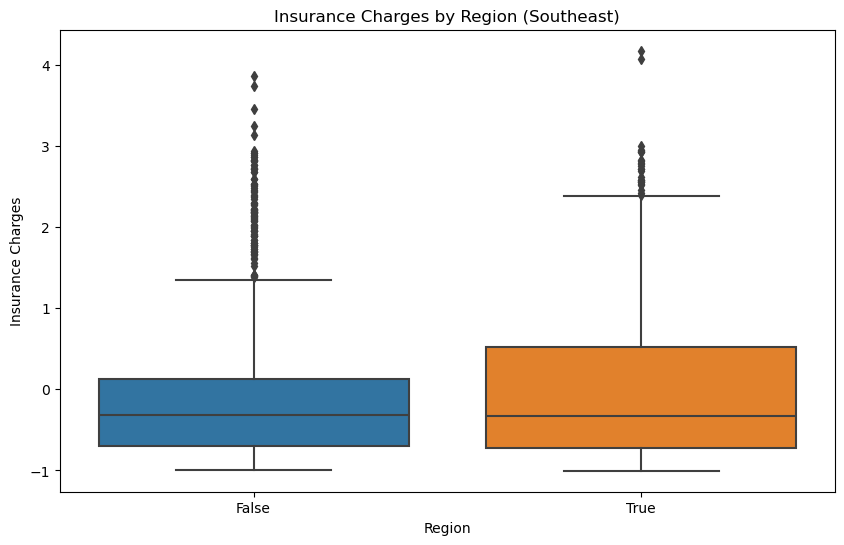

In [29]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='region_southeast', y='charges')
plt.title("Insurance Charges by Region (Southeast)")
plt.xlabel("Region")
plt.ylabel("Insurance Charges")
plt.show()

#### 2. Bar Plot of Average Charges by Region and Smoking Status:

#### Violin Plot of Charges by Age Group:

c:\Users\HP\New folder\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


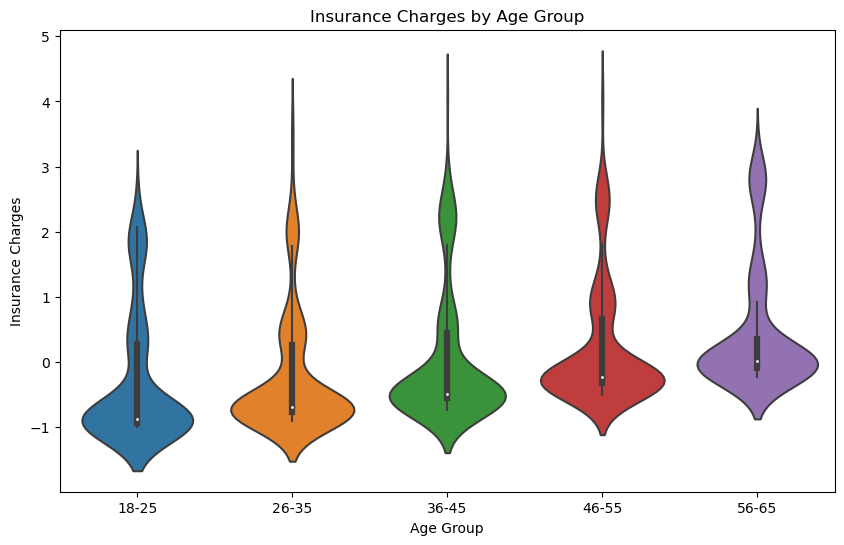

In [30]:
# Create age groups for the plot
df['age_group'] = pd.cut(df['age'], bins=[18, 25, 35, 45, 55, 65], labels=['18-25', '26-35', '36-45', '46-55', '56-65'])

plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x='age_group', y='charges')
plt.title("Insurance Charges by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Insurance Charges")
plt.show()


####  Predictive Modeling Insights

##### 1. Feature Importance Plot (for Random Forest):

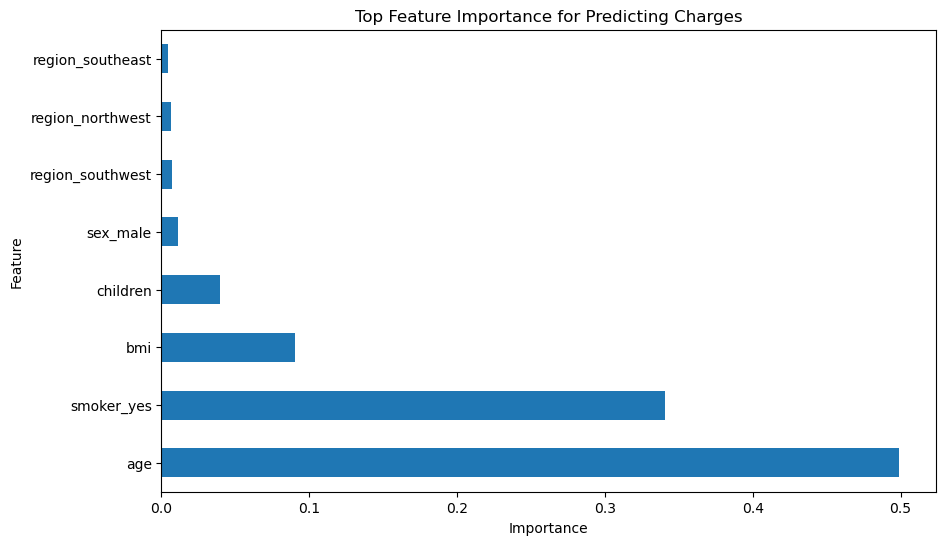

In [31]:
importances = best_rf_model.feature_importances_
feature_names = X.columns
feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
feature_importances.head(10).plot(kind='barh')
plt.title("Top Feature Importance for Predicting Charges")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

#### 2. Scatter Plot of Predicted vs. Actual Charges:

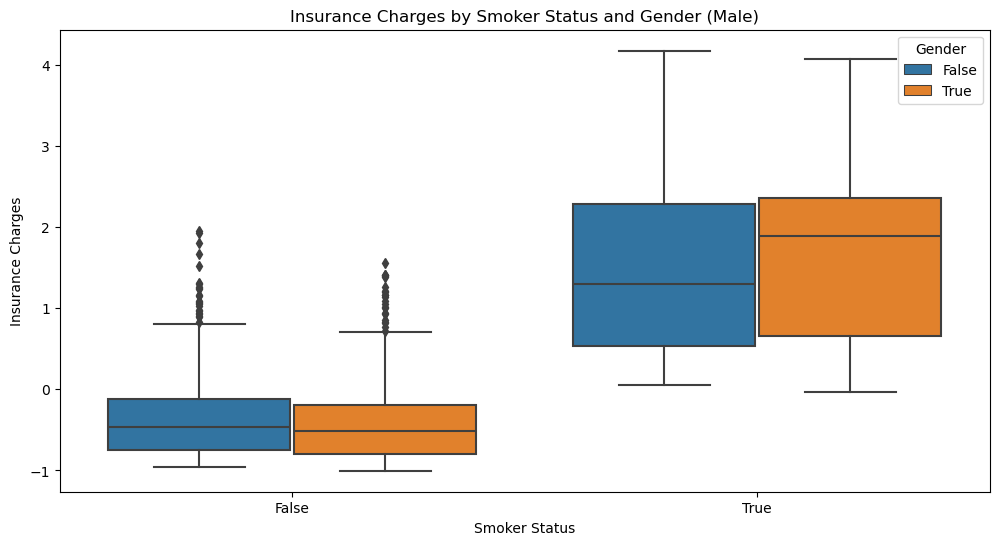

In [32]:
# Check if one-hot encoding created a new column for 'smoker'
# Adjust if the column is renamed after one-hot encoding
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='smoker_yes', y='charges', hue='sex_male')  # Adjust to actual column name
plt.title("Insurance Charges by Smoker Status and Gender (Male)")
plt.xlabel("Smoker Status")
plt.ylabel("Insurance Charges")
plt.legend(title="Gender")
plt.show()